In [99]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
#import matplotlib.pyplot as pyplot
import time
import numpy as np
import os
import sys

refineMesh = False

In [100]:
RES = 96
Xres, Yres = RES, RES
dim = 2
ALPHA = 11.

In [101]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"), 
                                         elementRes=(Xres, Yres), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(1.,1.05), periodic=[True,False] )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

In [102]:
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

In [103]:
if refineMesh:
    alpha=ALPHA
    newys = []
    newxs = []
    for index, coord in enumerate(linearMesh.data):
        y0 = coord[1]
        x0 = abs(coord[0])
        if y0 >= 1.0:
            newy = y0
        else:
            newy = (math.log(alpha*y0 + math.e) - 1)*(1/(math.log(alpha + math.e) - 1))
        newx = (math.log((alpha/2.)*x0 + math.e) - 1)*(1/(math.log((alpha/2.) + math.e) - 1))
        if coord[0] <= 0:
            newx = -1.*newx
        newys.append(newy)
        newxs.append(newx)
        
    with linearMesh.deform_mesh():
        linearMesh.data[:,1] = newys
        linearMesh.data[:,0] = newxs

In [104]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.

# Setup temperature initial condition via numpy arrays
A = 0.1
#Note that width = height = 1
tempNump = temperatureField.data
for index, coord in enumerate(linearMesh.data):
    pertCoeff = (1- coord[1]) + A*math.cos( math.pi * abs(1. - coord[0]) ) * math.sin( math.pi * coord[1] )
    tempNump[index] = pertCoeff;
    if coord[1] > 1:
        tempNump[index] = 0.

In [105]:
dres = 96
dummyelementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                         elementRes = (dres, dres), 
                                           minCoord = (0., 0.), 
                                           maxCoord = (1., 1.))

dummytemperatureMesh = dummyelementMesh 
dummytemperatureField = uw.fevariable.FeVariable( feMesh=dummytemperatureMesh, nodeDofCount=1 )
dummytemperatureField.load('temp_ics/temperatureField_4_10200.hdf5')

for index, coord in enumerate(elementMesh.data):
    #This bit determines whether you see a reflected image or not
    xpos, ypos = (coord[0]), coord[1]
    if ypos > 1.:
        temperatureField.data[index] = 0.
    else:
        temperatureField.data[index] = dummytemperatureField.evaluate((xpos, ypos))

            

In [106]:
 temperatureField.evaluate((0.5, 0.9))

array([[ 0.49268903]])

In [107]:
snum = 1000.
elsize = (linearMesh.data[:,0].max()- linearMesh.data[:,0].min())/linearMesh.elementRes[0]
dx = (linearMesh.data[:,0].max()- linearMesh.data[:,0].min())/snum
#yp = 1. - elsize/2.
yp = 0.9

linearMesh.data[:,0].max()
xps = np.linspace(linearMesh.data[:,0].min(),linearMesh.data[:,0].max(), snum)
yps = [yp for i in xps]

surfintswarm = uw.swarm.Swarm( feMesh=elementMesh )
dumout = surfintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)


tempgrad = temperatureField.gradientFn
valcheck = tempgrad[1].evaluate(surfintswarm)
valcheck.sum()

-2390.0197416834153

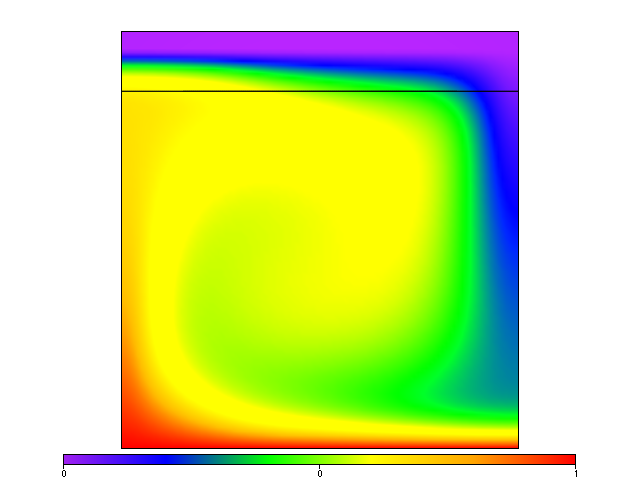

In [109]:
fig1 = plt.Figure()
#fig1.Surface(buoyancyFn[1], elementMesh)
fig1.Surface(temperatureField, elementMesh)
#fig1.Points( swarm=gSwarm, colourVariable=materialVariable , pointSize=0.5, colours='white blue red black')
#fig1.Mesh(linearMesh)
#fig1.VectorArrows(velocityField, linearMesh, lengthScale=0.002)
fig1.Points( swarm=surfintswarm,  pointSize=2.0)

fig1.show()
#fig1.save_database('test_mesh_refine.gldb')
